# Trabajo final LC POS-Tagging. Curso 2020-2021
### Jaime Ferrando Huertas
### Javier Martínez Bernia

## Preparamos los datos

In [60]:
#IMPORTS
import nltk
from nltk.corpus import cess_esp
from nltk.tag import UnigramTagger,BigramTagger,hmm, tnt, AffixTagger,brill, brill_trainer, CRFTagger
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from random import shuffle

nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to /Users/jaime/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [2]:
#Cargamos el corpus

corpus = list(cess_esp.tagged_sents())
number_sentences = len(corpus)
print("number of sentnces:", number_sentences)
print("number of words:", number_sentences)


number of sentnces: 6030
number of words: 6030


In [3]:
#Procesamos el corpus
processed_corpus = []
for sentence in corpus:
    tmp_sentence = []
    for word in sentence:
        if word[0] == "*0*":
            continue
        if word[1][0] == "v" or "F":
            new_word = (word[0], word[1][:2])
        else:
            new_word = (palabra_etiquetada[0], word[1][:1])
        tmp_sentence.append(new_word)
    processed_corpus.append(tmp_sentence)

In [4]:
# Shuffle data
shuffle(corpus)
shuffle(processed_corpus)

# Tarea 1 

// EXplicamos la tarea aqui

In [ ]:
%%time
results_hmm_unprocessed = []
intervals_hmm_unprocessed = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(corpus):
    #Split data
    training_cv = np.take(corpus,train_index)
    test_cv = np.take(corpus,test_index)
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_cv)
    v = tagger_hmm.evaluate(test_cv)
    results_hmm_unprocessed.append(v)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/len(test_cv))
    ic = round(d,3)
    intervals_hmm_unprocessed.append(ic)

results_hmm_processed = []
intervals_hmm_processed = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(processed_corpus):
    #Split data
    training_cv = np.take(corpus,train_index)
    test_cv = np.take(corpus,test_index)
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_cv)
    v = tagger_hmm.evaluate(test_cv)
    results_hmm_processed.append(v)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/len(test_cv))
    ic = round(d,3)
    intervals_hmm_processed.append(ic)
    


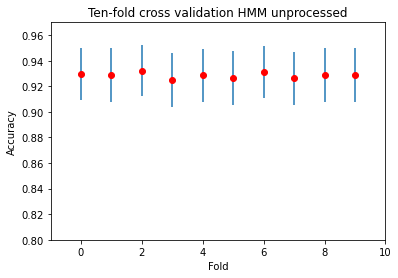

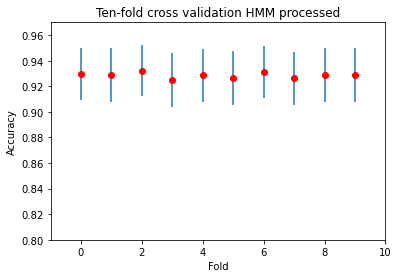

In [29]:
x=[i for i in range(10)]
y=results_hmm_unprocessed # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM unprocessed')
plt.plot(x,y,'ro')
Tic=intervals_hmm_unprocessed# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

x=[i for i in range(10)]
y=results_hmm_processed # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM processed')
plt.plot(x,y,'ro')
Tic=intervals_hmm_processed# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

// Comentamos resultados

# Tarea 2

// EXplicamos la tarea aqui

In [31]:
%%time
results_hmm_train_limited = []
intervals_hmm_train_limited = []
for i in np.arange(0.1, 1.0, 0.1): #We iterate a list array([0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])
    #Split data
    len_training = int(i*len(processed_corpus))
    training_notcv = processed_corpus[:len_training]
    test_notcv = processed_corpus[len_training:]
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_notcv)
    v = tagger_hmm.evaluate(test_notcv)
    results_hmm_train_limited.append(v)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/len(test_cv))
    ic = round(d,3)
    intervals_hmm_train_limited.append(ic)
    


CPU times: user 5min 49s, sys: 16 s, total: 6min 5s
Wall time: 6min 20s


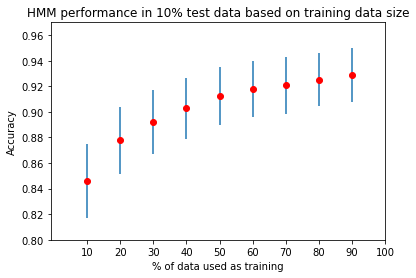

In [46]:
xticks = np.arange(10, 110, step=10)
x=xticks[:9]
y=results_hmm_train_limited # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.xticks(xticks)
plt.ylabel('Accuracy')
plt.xlabel('% of data used as training')
plt.title('HMM performance in 10% test data based on training data size')
plt.plot(x,y,'ro')
Tic=intervals_hmm_train_limited# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

// Comentamos resultados

# Tarea 3

In [47]:
def tr_te_tnt_smooth(tr,te,n):
    # n: longitud del sufijo
    # Entrenamos y evaluamos el tagger tnt con suavizado utilizando
    # AffixTagger como etiquetador para las palabras desconocidas
    
    # Inicializamos y entrenamos AffixTagger
    sufix_tagger = AffixTagger(tr, affix_length=-n)
    # Inicializamos TnT pasando el tagger anterior como parámetro
    tnt_tagger = tnt.TnT(unk = sufix_tagger, Trained = True)
    # Entrenamos TnT
    tnt_tagger.train(tr)
    # Evaluamos con te
    return tnt_tagger.evaluate(te)


In [56]:
%%time
from nltk import AffixTagger
results_tnt_affix_length = []
intervals_tnt_affix_length = []
for i in range(0, 10):
    #Split data
    len_training = int(0.9*len(processed_corpus))
    training_notcv = processed_corpus[:len_training]
    test_notcv = processed_corpus[len_training:]
    #Mofidy data for affix
    #TNT
    v = tr_te_tnt_smooth(training_notcv,test_notcv,i)
    results_tnt_affix_length.append(v)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/len(test_cv))
    ic = round(d,3)
    intervals_tnt_affix_length.append(ic)

CPU times: user 5min 49s, sys: 4.41 s, total: 5min 53s
Wall time: 6min 9s


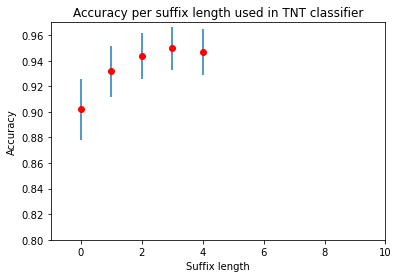

In [59]:
xticks = list(range(10))
x=xticks
y=results_tnt_affix_length # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.97])
plt.ylabel('Accuracy')
plt.xlabel('Suffix length')
plt.title('Accuracy per suffix length used in TNT classifier')
plt.plot(x,y,'ro')
Tic=intervals_tnt_affix_length# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

# Tarea 4

In [67]:
%%time
train = processed_corpus[:int(0.9*len(corpus))]
test = processed_corpus[int(0.9*len(corpus)):]

tagger_unigramas = UnigramTagger(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
trainer._trace=0 #We hide the training loop prints
tagger_brill = trainer.train(train, max_rules=1000)

CPU times: user 44.6 s, sys: 490 ms, total: 45.1 s
Wall time: 46.3 s


In [68]:
# Brill with unigramtagger
tagger_brill.evaluate(test)

0.901081276837912

In [69]:
tagger_unigramas = hmm.HiddenMarkovModelTagger.train(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
trainer._trace=0 #We hide the training loop prints
tagger_brill = trainer.train(train, max_rules=1000)

In [70]:
# Brill with hmmtagger
tagger_brill.evaluate(test)

0.9302602307413731